# Preliminary data cleaning for *Currais et al.*

Tong Shu Li

We clean up the data in [PMID:26564964](http://www.ncbi.nlm.nih.gov/pubmed/26564964) for analysis. We remove any genes with zero expression so that drift can be calculated.

## Data source

The raw data for [PMID:26564964](http://www.ncbi.nlm.nih.gov/pubmed/26564964) can be downloaded from [GSE69244](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE69244).

The original raw data had 12 mouse samples, 4 for each of the three conditions: young reference, old untreated mice, and old treated mice.

However, the public GSE69244 data has two mice removed: old J147 treated mouse replicate 4, and old control mouse replicate 1. The data Michael sent me has corrupted gene id names (things like "March9" converted to the date 9-Mar by Excel).

For these reasons, I will go with the published GSE file, since these data are already public.

We can use the raw counts of each gene directly, since normalization to the FPKM divides each value by the same constant, which is irrelevant when calculating drift.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
%matplotlib inline

## Read the raw gene counts

In [3]:
raw = pd.read_csv("GSE69244_count_matrix.csv", sep = ',')

In [4]:
raw.shape

(24015, 11)

In [5]:
raw = raw.rename(columns = {"Gene": "gene_id"})

In [6]:
raw.head()

,gene_id,old_J147.1,old_J147.2,old_J147.3,old_untreated.1,old_untreated.2,old_untreated.3,young.1,young.2,young.3,young.4
0,Xkr4,92,141,169,64,87,84,113,147,62,93
1,Rp1,0,0,1,1,1,1,1,1,0,2
2,Sox17,80,106,95,88,82,95,65,85,70,74
3,Mrpl15,421,405,395,402,370,370,295,319,212,356
4,Lypla1,309,290,362,311,295,337,241,263,158,288


---

## Read the MGI gene mapping information

We will assign a MGI identifier to each gene so that we can exmaine the Gene Ontology annotations later on in the analysis.

The file `MRK_List2.rpt` is downloaded from ftp://ftp.informatics.jax.org/pub/reports/MRK_List2.rpt

In [7]:
mgi = pd.read_csv("MRK_List2.rpt", sep = '\t')

In [8]:
mgi.shape

(128881, 12)

In [9]:
mgi.head()

,MGI Accession ID,Chr,cM Position,genome coordinate start,genome coordinate end,strand,Marker Symbol,Status,Marker Name,Marker Type,Feature Type,Marker Synonyms (pipe-separated)
0,MGI:1341858,5,syntenic,NaN,NaN,NaN,03B03F,O,"DNA segment, 03B03F (Research Genetics)",BAC/YAC end,BAC/YAC end,NaN
1,MGI:1341869,5,syntenic,NaN,NaN,NaN,03B03R,O,"DNA segment, 03B03R (Research Genetics)",BAC/YAC end,BAC/YAC end,NaN
2,MGI:1337005,11,syntenic,NaN,NaN,NaN,03.MMHAP34FRA.seq,O,"DNA segment, 03.MMHAP34FRA.seq",DNA Segment,DNA segment,NaN
3,MGI:1918911,7,29.36,45567795.0,45575176.0,-,0610005C13Rik,O,RIKEN cDNA 0610005C13 gene,Gene,lncRNA gene,NaN
4,MGI:1923503,7,syntenic,74823614.0,74853809.0,NaN,0610006L08Rik,O,RIKEN cDNA 0610006L08 gene,Gene,lincRNA gene,NaN


## Create gene name mapping dict

Since genes can be synonyms of one another, we will prefer the official gene symbol before we use a synonym.

For example, the gene "Pex2" may refer to [MGI:107486](http://www.informatics.jax.org/marker/MGI:107486) or [MGI:1916672](http://www.informatics.jax.org/marker/MGI:1916672).

For the first option, Pex2 is the official gene symbol, while for the second gene, Pex2 is a synonym and not the official gene symbol. In this case, we will map Pex2 to MGI:107486, since it matches the official gene symbol.

In [10]:
def get_mapping():
    official = dict()
    synonyms = dict()

    for idx, row in mgi.iterrows():
        mgi_id = row["MGI Accession ID"]
        symbol = row["Marker Symbol"]
        
        official[symbol] = mgi_id

        temp = row["Marker Synonyms (pipe-separated)"]
        if isinstance(temp, str):
            vals = temp.split("|")
            for val in vals:
                synonyms[val] = mgi_id
                
    return (official, synonyms)

In [11]:
off, syn = get_mapping()

In [12]:
len(off)

128594

In [13]:
len(syn)

82932

In [14]:
len(set(off.keys()) & set(syn.keys()))

824

There are 824 gene names which are both official gene names and synonyms for other genes. An exmaple is "109F12R", which maps to both [MGI:1860916](http://www.informatics.jax.org/marker/MGI:1860916) and [MGI:1343125](http://www.informatics.jax.org/marker/MGI:1343125).

In [15]:
# create one mapping with no redundancy
mapping = off.copy()
for key, val in syn.items():
    if key not in mapping:
        mapping[key] = val

In [16]:
len(mapping)

210702

In [17]:
# number of genes which have mappings
len(set(raw["gene_id"]) & set(mapping.keys()))

23923

In [18]:
raw["gene_id"].nunique()

24015

In [19]:
# gene names without mappings to MGI ids
set(raw["gene_id"]) - set(mapping.keys())

{'0610010B08Rik',
 '1700024F13Rik',
 '4931412M21',
 'A230073K19Rik',
 'A630020A06',
 'AU018829',
 'C230029M16',
 'Cistr-act',
 'D130058E03',
 'E030019B06Rik',
 'Esp6-esp5',
 'Evi2a-evi2b',
 'Gm11570',
 'Gm13308',
 'Gm17757',
 'Jmjd7-pla2g4b',
 'Klra33',
 'LOC100038947',
 'LOC100040786',
 'LOC100043315',
 'LOC100048884',
 'LOC100502896',
 'LOC100503280',
 'LOC100503496',
 'LOC100503676',
 'LOC100504039',
 'LOC100504608',
 'LOC100504703',
 'LOC100505025',
 'LOC100861615',
 'LOC100861978',
 'LOC100862015',
 'LOC100862268',
 'LOC101055769',
 'LOC101055863',
 'LOC101056043',
 'LOC101056136',
 'LOC101056149',
 'LOC101056236',
 'LOC101243624',
 'LOC101669761',
 'LOC102308570',
 'LOC102631757',
 'LOC102632423',
 'LOC102632430',
 'LOC102633035',
 'LOC102633315',
 'LOC102634101',
 'LOC102634401',
 'LOC102634431',
 'LOC102634753',
 'LOC102635087',
 'LOC102636514',
 'LOC106740',
 'LOC171588',
 'LOC381967',
 'LOC547349',
 'LOC666331',
 'Lincrna-cox2',
 'Mir126',
 'Mir145',
 'Mir1843',
 'Mir190',
 '

In [20]:
len(set(raw["gene_id"]) - set(mapping.keys()))

92

Of the 24015 genes in the dataset, we could not map 92 of the genes to a MGI identifier. Since 23923 of 24015 genes (99.6%) could be mapped, we will not worry about the remaining 92 unmappable genes.

## Map genes to MGI identifier

In [21]:
raw["mgi_id"] = raw["gene_id"].map(
    lambda v: mapping[v] if v in mapping else "unknown"
)

In [22]:
temp = raw["mgi_id"].value_counts()
temp[temp > 1]

unknown        92
MGI:2685821     3
MGI:3780250     2
MGI:1341833     2
MGI:3031268     2
MGI:1346342     2
MGI:2443973     2
MGI:3040687     2
MGI:1920574     2
MGI:3690448     2
MGI:2139758     2
MGI:1924923     2
MGI:2686021     2
MGI:2384034     2
MGI:1918708     2
Name: mgi_id, dtype: int64

Some genes seem to have been measured multiple times.

In [23]:
raw.query("mgi_id == 'unknown'")

,gene_id,old_J147.1,old_J147.2,old_J147.3,old_untreated.1,old_untreated.2,old_untreated.3,young.1,young.2,young.3,young.4,mgi_id
887,Lincrna-cox2,2,3,4,2,4,2,5,3,1,4,unknown
1715,LOC102634101,10,2,8,10,4,13,4,6,5,5,unknown
2243,C230029M16,8,6,0,4,6,4,1,2,4,3,unknown
2289,LOC100504608,3,2,3,2,0,3,3,0,1,3,unknown
2295,LOC100504703,8,6,6,9,12,3,7,11,4,3,unknown
3120,Tnfsf12Tnfsf13,0,0,0,0,0,0,0,0,0,0,unknown
3164,Mir195,0,0,0,0,0,0,0,0,0,0,unknown
3357,Mir451,0,0,0,0,0,0,0,0,0,0,unknown
3402,Evi2a-evi2b,0,0,0,0,0,0,0,0,0,0,unknown
3407,Mir193,0,0,0,0,0,0,0,0,0,0,unknown


Seems like the genes which have no MGI identifiers are mostly empty (no measured expression). This is good since they will be filtered out.

In [24]:
raw.query("mgi_id != 'unknown'").groupby("mgi_id").filter(lambda df: len(df) > 1).sort_values("mgi_id")

,gene_id,old_J147.1,old_J147.2,old_J147.3,old_untreated.1,old_untreated.2,old_untreated.3,young.1,young.2,young.3,young.4,mgi_id
5116,Prl2c3,0,0,0,0,0,0,0,0,0,0,MGI:1341833
5115,Prl2c4,0,0,0,0,0,0,0,0,0,0,MGI:1341833
14102,Clca3,1,0,0,0,2,1,0,0,0,0,MGI:1346342
14096,Clca1,3,3,10,10,12,8,6,9,8,9,MGI:1346342
23034,2900008C10Rik,44,55,52,43,43,41,47,49,32,57,MGI:1918708
23033,Bcor,464,536,546,313,378,428,523,553,367,577,MGI:1918708
15232,Clhc1,0,0,1,2,2,1,1,1,1,0,MGI:1920574
2637,1700034F02Rik,0,3,2,2,2,3,0,1,0,0,MGI:1920574
66,Defb41,0,0,0,0,0,0,0,0,0,0,MGI:1924923
67,Gm15386,0,0,0,0,0,0,0,0,0,0,MGI:1924923


Some of the genes which were measured twice seem to have no expression either way, which is ok since they will be filtered out. Some other genes though seem to have different expression values, which will be more complicated.

In [25]:
# drop the column for now
# we will re-add the column when the data is in long form
raw = raw.drop("mgi_id", axis = 1)

## Number of unique genes

In [26]:
raw["gene_id"].nunique()

24015

## Any empty cells?

In [27]:
raw.isnull().sum()

gene_id            0
old_J147.1         0
old_J147.2         0
old_J147.3         0
old_untreated.1    0
old_untreated.2    0
old_untreated.3    0
young.1            0
young.2            0
young.3            0
young.4            0
dtype: int64

## Read sample metadata

In [28]:
metadata = pd.read_csv("sample_metadata.tsv", sep = '\t')

In [29]:
metadata

,sample,months_old,drug_given,replicate,sample_name
0,1,3,vehicle,1,young.1
1,2,3,vehicle,2,young.2
2,3,3,vehicle,3,young.3
3,4,3,vehicle,4,young.4
4,5,10,vehicle,1,old_untreated.1
5,6,10,vehicle,2,old_untreated.2
6,7,10,vehicle,3,old_untreated.3
7,8,10,j147,1,old_J147.1
8,9,10,j147,2,old_J147.2
9,10,10,j147,3,old_J147.3


## Restructure the data to long format

Columns: gene_name, months_old, drug, replicate

In [30]:
def reshape(data, metadata):
    def make_df(column):
        sub = data.loc[:, ["gene_id", column]]
        sub = sub.rename(columns = {column: "gene_count"})
        sub["sample_name"] = column
        return sub
    
    temp = [
        make_df(column)
        for column in data.columns if column != "gene_id"
    ]
    
    return pd.concat(temp).reset_index(drop = True)

In [31]:
long = reshape(raw, metadata)

data = pd.merge(long, metadata, how = "left", on = "sample_name")

In [32]:
data["mgi_id"] = data["gene_id"].map(
    lambda v: mapping[v] if v in mapping else "unknown"
)

In [33]:
data.head()

,gene_id,gene_count,sample_name,sample,months_old,drug_given,replicate,mgi_id
0,Xkr4,92,old_J147.1,8,10,j147,1,MGI:3528744
1,Rp1,0,old_J147.1,8,10,j147,1,MGI:1341105
2,Sox17,80,old_J147.1,8,10,j147,1,MGI:107543
3,Mrpl15,421,old_J147.1,8,10,j147,1,MGI:1351639
4,Lypla1,309,old_J147.1,8,10,j147,1,MGI:1344588


In [34]:
data.shape

(240150, 8)

## How many genes with zero expression did each sample have?

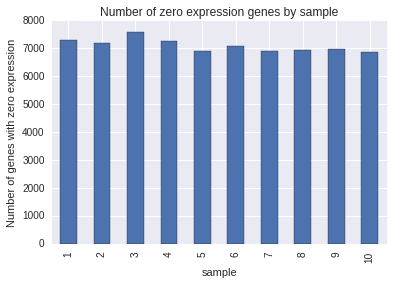

In [35]:
fig = data.groupby("sample").apply(lambda df: (df["gene_count"] == 0).sum()).plot(kind = "bar")
fig.set_ylabel("Number of genes with zero expression")
fig.set_title("Number of zero expression genes by sample")

## Number of genes with zero expression in all samples

In [36]:
(data.groupby("gene_id")["gene_count"].sum() == 0).sum()

5049

5049 of 24015 genes had no expression value across all 10 of the samples, and therefore need to be excluded from further analysis.

## Filter genes which were zero in all samples

We can't calculate drift for genes which have zero expression. These data have no null values, but a bunch of zeroes instead.

In [37]:
good = data.groupby("gene_id").filter(lambda df: df["gene_count"].sum() > 0)

In [38]:
good.shape

(189660, 8)

In [39]:
good.head()

,gene_id,gene_count,sample_name,sample,months_old,drug_given,replicate,mgi_id
0,Xkr4,92,old_J147.1,8,10,j147,1,MGI:3528744
1,Rp1,0,old_J147.1,8,10,j147,1,MGI:1341105
2,Sox17,80,old_J147.1,8,10,j147,1,MGI:107543
3,Mrpl15,421,old_J147.1,8,10,j147,1,MGI:1351639
4,Lypla1,309,old_J147.1,8,10,j147,1,MGI:1344588


In [40]:
good["gene_id"].nunique()

18966

## Mean expression of each gene across all samples

Remaining genes may still have zero expression in some of the ten samples. Let's plot the mean expression of each gene across all samples.

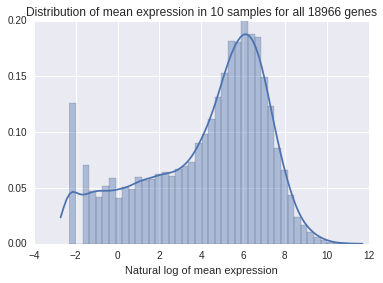

In [41]:
means = good.groupby("gene_id")["gene_count"].mean()

fig = sns.distplot(np.log(means))
fig.set_title("Distribution of mean expression in 10 samples for all 18966 genes")
fig.set_xlabel("Natural log of mean expression")

## Filter any remaining zeroes

Unfortunately we can't have zeroes in either the old or young sample, since the log will give negative infinity. We therefore remove any genes which are zero in any sample.

In [42]:
clean = good.groupby("gene_id").filter(lambda df: all(df["gene_count"] > 0)).reset_index(drop = True)

In [43]:
clean.shape

(152520, 8)

In [44]:
clean.head()

,gene_id,gene_count,sample_name,sample,months_old,drug_given,replicate,mgi_id
0,Xkr4,92,old_J147.1,8,10,j147,1,MGI:3528744
1,Sox17,80,old_J147.1,8,10,j147,1,MGI:107543
2,Mrpl15,421,old_J147.1,8,10,j147,1,MGI:1351639
3,Lypla1,309,old_J147.1,8,10,j147,1,MGI:1344588
4,Tcea1,224,old_J147.1,8,10,j147,1,MGI:1196624


In [45]:
(clean["gene_count"] == 0).sum()

0

In [46]:
clean["gene_id"].nunique()

15252

We are left with 15252 genes which have a gene count of at least 1 in all samples. We can calculate the drift for these genes.

## Add the log count column

In [47]:
clean["log_count"] = np.log(clean["gene_count"])

In [48]:
clean.head()

,gene_id,gene_count,sample_name,sample,months_old,drug_given,replicate,mgi_id,log_count
0,Xkr4,92,old_J147.1,8,10,j147,1,MGI:3528744,4.521789
1,Sox17,80,old_J147.1,8,10,j147,1,MGI:107543,4.382027
2,Mrpl15,421,old_J147.1,8,10,j147,1,MGI:1351639,6.042633
3,Lypla1,309,old_J147.1,8,10,j147,1,MGI:1344588,5.733341
4,Tcea1,224,old_J147.1,8,10,j147,1,MGI:1196624,5.411646


## Mean count distribution for all genes

What does the distribution look like after filtering all the zeroes?

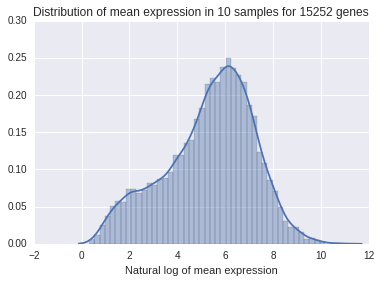

In [49]:
means = clean.groupby("gene_id")["log_count"].mean()

fig = sns.distplot(means)
fig.set_title("Distribution of mean expression in 10 samples for 15252 genes")
fig.set_xlabel("Natural log of mean expression")

This looks much nicer.

---

## Drop genes which were sequenced twice

Since we have ten samples, and each gene should have only been sequenced once, we will drop all genes which were sequenced more than once, or which has no MGI id, since we will not be able to examine the GO terms later.

In [50]:
clean["mgi_id"].value_counts().head()

unknown        160
MGI:3040687     20
MGI:2686021     20
MGI:1918708     20
MGI:106676      10
Name: mgi_id, dtype: int64

In [51]:
clean = clean.groupby("mgi_id").filter(lambda df: len(df) == 10)

In [52]:
all(clean["mgi_id"].value_counts() == 10)

True

In [53]:
clean["mgi_id"].nunique()

15230

We only filtered an additional 22 genes (15252 to 15230) by removing those which had no MGI id or were sequenced multiple times. We are left with a total of 15230 unique genes (as decided by MGI id).

## Write to file

In [54]:
clean.to_csv("filtered_expression.tsv", sep = '\t', index = False)